# Test plane extraction for a single point cloud

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import time
import open3d as o3d

import planeslam.general as general
from planeslam.mesh import LidarMesh
from planeslam.scanrep import ScanRep
from planeslam.extraction import scan_from_clusters
from planeslam.clustering import cluster_mesh_graph_search

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


ImportError: cannot import name 'mesh_cluster_pts' from 'planeslam.clustering' (c:\users\adam\navlab\lidar slam\planeslam\planeslam\clustering.py)

Read Point Cloud from pcd file

In [7]:
# Read in point cloud data
pcfile = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_100.pcd')
pcd = o3d.io.read_point_cloud(pcfile)
P = np.asarray(pcd.points)

In [8]:
# Convert points to ENU
P = general.NED_to_ENU(P)

Cluster the points

In [9]:
# Create the mesh
mesh = LidarMesh(P)
mesh.prune(10)
start_time = time.time()
# Cluster the mesh with graph search
clusters, avg_normals = cluster_mesh_graph_search(mesh)
print("elapsed time: ", time.time() - start_time)

AttributeError: 'LidarMesh' object has no attribute 'simplices'

In [4]:
start_time = time.time()
P = general.downsample(P, factor=5, axis=0)
m = mesh.lidar_mesh(P)
# Prune the mesh for long edges
m = mesh.prune_mesh(P, m, 10)
# Cluster the mesh with graph search
clusters, avg_normals = mesh.cluster_mesh_graph_search(P, m)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.14203214645385742


Text(0.5, 0.5, 'Y')

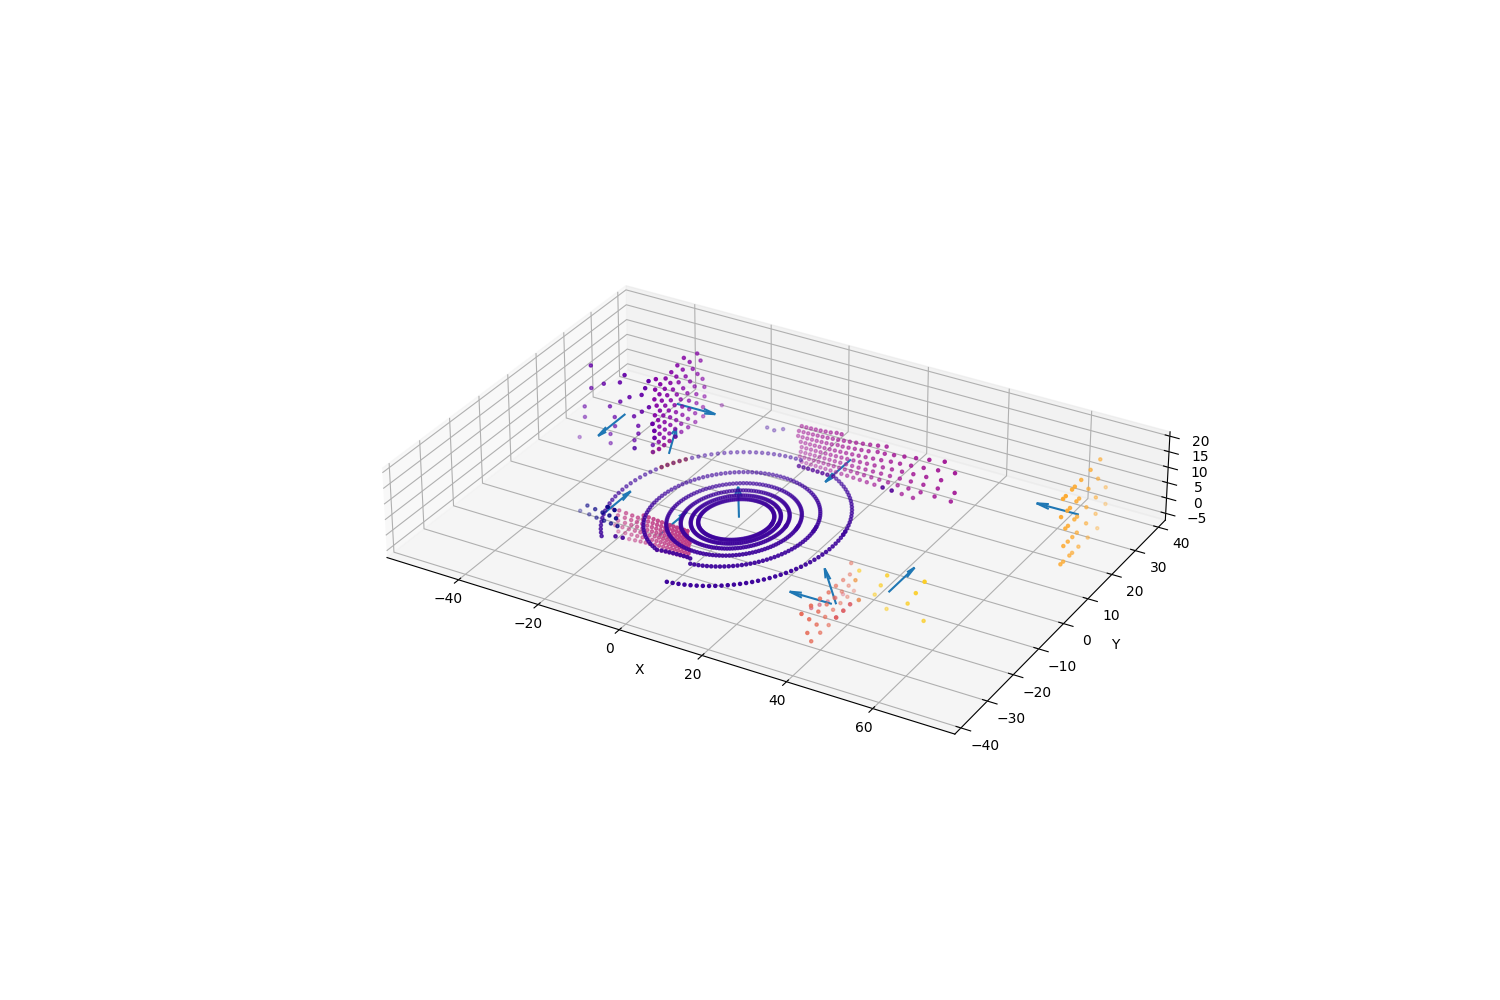

In [5]:
# Plot clusters
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, c in enumerate(clusters):
    cluster_pts_idxs = np.unique(m.simplices[c,:]) 
    cluster_pts = P[cluster_pts_idxs,:]
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color=colors[i,:], marker='.')  

    # Show normals
    c = np.mean(cluster_pts, axis=0)
    n = 10 * avg_normals[i]
    ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2])

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")


Text(0.5, 0.5, 'Y')

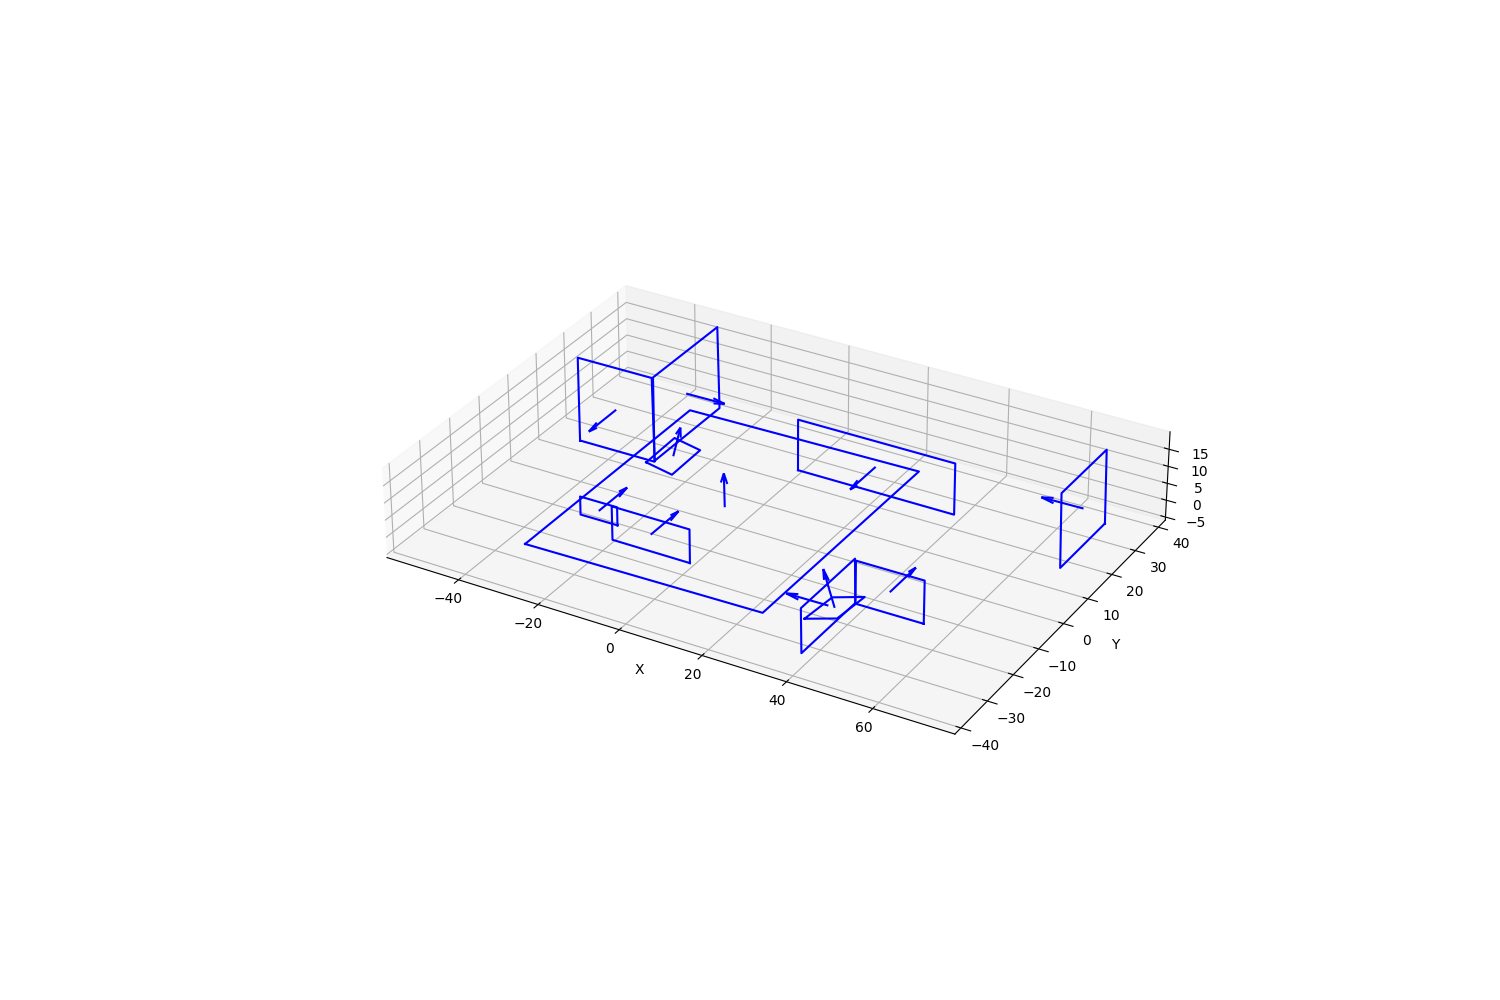

In [6]:
from planeslam.extraction import bd_plane_from_pts
from planeslam.plane import BoundedPlane

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i, c in enumerate(clusters):
    n = avg_normals[i][:,None]
    cluster_pts_idxs = np.unique(m.simplices[c,:]) 
    cluster_pts = P[cluster_pts_idxs,:]

    verts = bd_plane_from_pts(cluster_pts, n)
    bplane = BoundedPlane(verts)
    bplane.plot(ax, show_normal=True)

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Extract planes

In [7]:
vertices, faces, normals = scan_from_clusters(P, m, clusters, avg_normals)
scan = ScanRep(vertices, faces, normals)

Text(0.5, 0.5, 'Y')

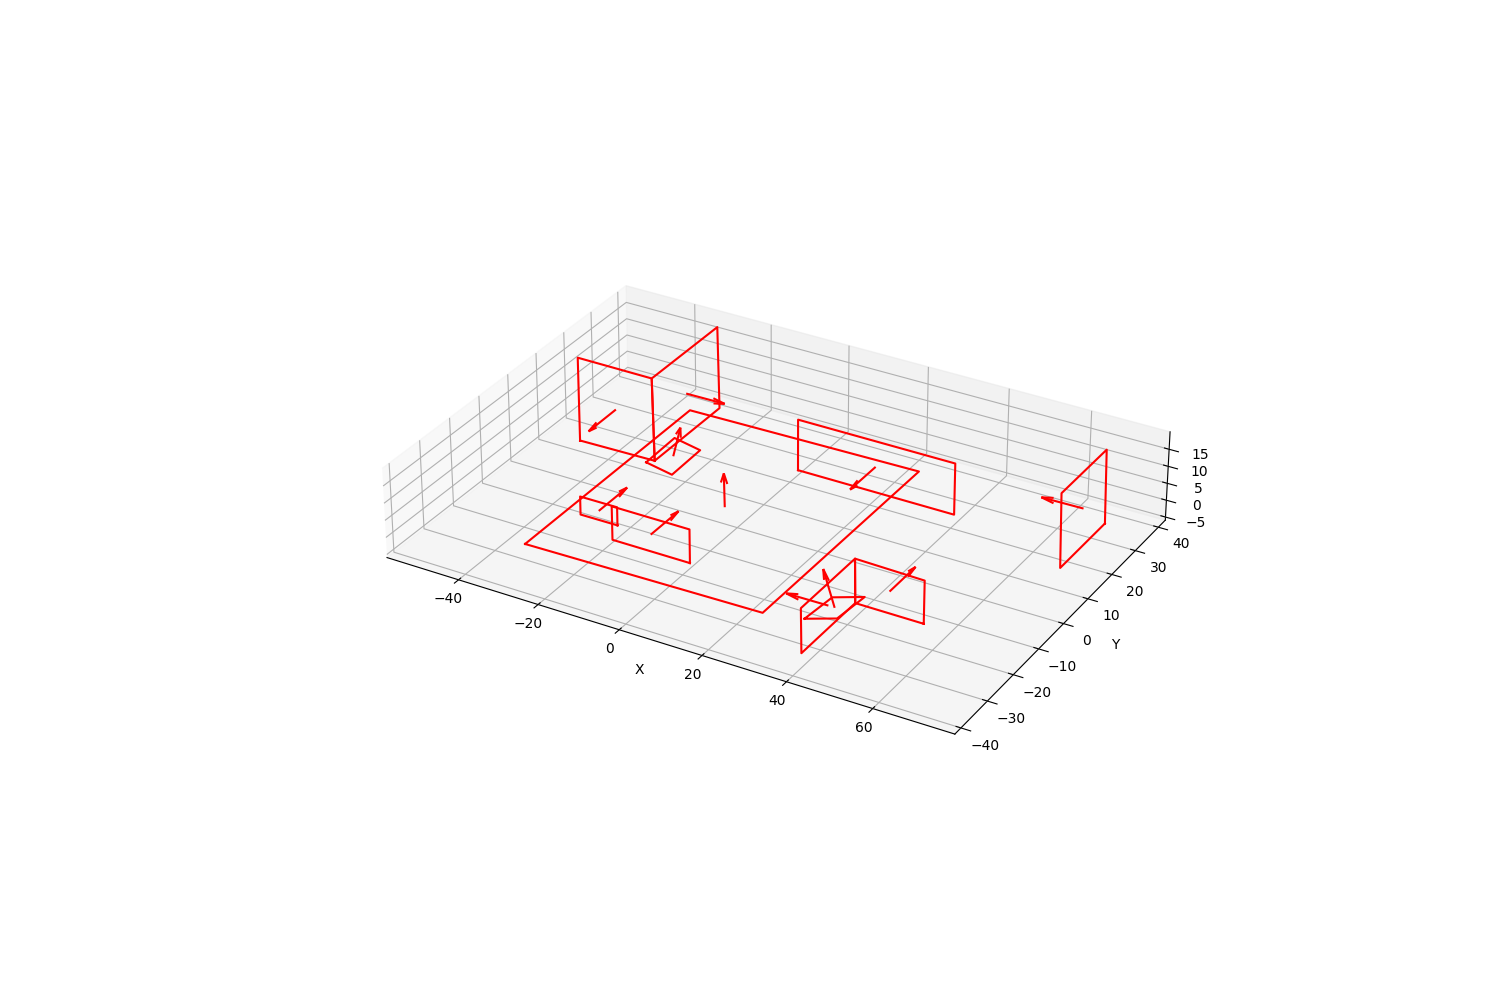

In [8]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scan.plot(ax, color='r', show_normals=True)

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")